This code plots the bootstrapped partial dependence plots

In [1]:
# import libraries
library(data.table)
library(ggplot2)
library(ggthemes)
library(gridExtra)
library(extrafont)

Warning message:
"package 'data.table' was built under R version 3.4.4"Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'ggthemes' was built under R version 3.4.4"Warning message:
"package 'gridExtra' was built under R version 3.4.4"Warning message:
"package 'extrafont' was built under R version 3.4.4"Registering fonts with R


In [2]:
cbbPalette <- c('#009E73',"#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9", "#E69F00", "#F0E442")
# cnn (green), gam (yellow), boosted tree (dark blue), mars (red), mlr (pink), rf (light blue)
#https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7

In [3]:
grid.size <- 500

In [4]:
# import the data
dt = fread(paste0('../../data/regression/results_partial_dependents_', grid.size, '_all.csv'))

# import raw data for the histograms
df = fread(paste0('../../data/data_regressions_', grid.size,'_20200303_unnormalized.csv'))

In [5]:
summary(df)

       V1          alb_max         alb_max_sl       alb_mean    
 Min.   :   0   Min.   : 6.317   Min.   :10.37   Min.   : 5.91  
 1st Qu.:2003   1st Qu.:18.724   1st Qu.:20.53   1st Qu.:12.22  
 Median :4006   Median :24.148   Median :25.77   Median :15.77  
 Mean   :4006   Mean   :26.225   Mean   :26.20   Mean   :15.50  
 3rd Qu.:6008   3rd Qu.:31.014   3rd Qu.:30.79   3rd Qu.:18.63  
 Max.   :8011   Max.   :74.378   Max.   :54.32   Max.   :33.05  
  alb_mean_sl       alb_min         alb_min_sl         alb_sd        
 Min.   : 7.08   Min.   : 5.290   Min.   : 5.634   Min.   : 0.06551  
 1st Qu.:12.33   1st Qu.: 9.494   1st Qu.: 9.489   1st Qu.: 1.31275  
 Median :15.66   Median :10.945   Median :10.936   Median : 2.01472  
 Mean   :15.50   Mean   :11.351   Mean   :11.346   Mean   : 2.51268  
 3rd Qu.:18.69   3rd Qu.:13.594   3rd Qu.:13.522   3rd Qu.: 3.14949  
 Max.   :26.04   Max.   :22.074   Max.   :18.487   Max.   :17.49468  
   alb_sd_sl            bldg            city           

In [6]:
summary(df)

       V1          alb_max         alb_max_sl       alb_mean    
 Min.   :   0   Min.   : 6.317   Min.   :10.37   Min.   : 5.91  
 1st Qu.:2003   1st Qu.:18.724   1st Qu.:20.53   1st Qu.:12.22  
 Median :4006   Median :24.148   Median :25.77   Median :15.77  
 Mean   :4006   Mean   :26.225   Mean   :26.20   Mean   :15.50  
 3rd Qu.:6008   3rd Qu.:31.014   3rd Qu.:30.79   3rd Qu.:18.63  
 Max.   :8011   Max.   :74.378   Max.   :54.32   Max.   :33.05  
  alb_mean_sl       alb_min         alb_min_sl         alb_sd        
 Min.   : 7.08   Min.   : 5.290   Min.   : 5.634   Min.   : 0.06551  
 1st Qu.:12.33   1st Qu.: 9.494   1st Qu.: 9.489   1st Qu.: 1.31275  
 Median :15.66   Median :10.945   Median :10.936   Median : 2.01472  
 Mean   :15.50   Mean   :11.351   Mean   :11.346   Mean   : 2.51268  
 3rd Qu.:18.69   3rd Qu.:13.594   3rd Qu.:13.522   3rd Qu.: 3.14949  
 Max.   :26.04   Max.   :22.074   Max.   :18.487   Max.   :17.49468  
   alb_sd_sl            bldg            city           

# Plot the PDPs

In [7]:
plots <- list()
ncol.plot <- 5
# xlims <- c(0,30)

In [8]:
feature_names <- c('lcov_11' = '% water','tree_mean'='% tree canopy','ndvi_mean'='ndvi','svf_mean'='sky view factor',
                    'dsm_mean'='digital surface model','alb_mean'='albedo','dsm_sd'='dsm stand. dev.','nbdi_max'='max nbdi',
                    'tree_max'='max % tree can.', 'tree_min'='min % tree can.',
                    'bldg'='% building area','pdens_mean'='pop. density',
                    'tree_sd'= '% tree can. stand. dev.', 'nbdi_sd_sl'='nbdi surrounding stand. dev.',
                    'tree_sd_sl'='% tree can. surrounding stand. dev.',
                    'ndvi_sd'= 'ndvi stand. dev'   )

In [9]:
# calculate the histogram for each of the features
# df_hist <- df[density_housesarea > xlims[1] & density_housesarea < xlims[2],]

In [10]:
if (grid.size == 500){
    hist_scaling <- c(20, 0.8, 12, 0.35, 400, 200, 30, 0.7, 60, 7000)
    } else {
    hist_scaling <- c(35, 0.9, 1.3, 0.45, 400, 
                      250, 10, 0.15, 35, 6000)
}

In [11]:
font.size <- 15

In [12]:
dt_sub <- dt[dependent == 'lst_night_mean',]
plots <- list()
# import the feature order
if (grid.size == 500){
    features = c('tree_mean', 'ndvi_mean', 'lcov_11', 'svf_mean', 'alb_mean')#, 'alb_mean', 'tree_max', 'nbdi_max', 'bldg', 'pdens_mean')
    hist_scaling <- c(20, 0.8, 12, 0.35, 40)
    } else {
    features = c('tree_mean', 'ndvi_mean', 'alb_mean', 'svf_mean', 'dsm_mean')#, 'alb_mean', 'tree_sd', 'nbdi_sd_sl', 'bldg', 'pdens_mean')
    hist_scaling <- c(25, 0.9, 250, 0.45, 400)
}
# determine the axis limits
y_min <- -8#round(min(dt[,'mean'])*2)/2
y_max <- 5#round(max(dt[,'mean'])*2)/2
ylims <- c(y_min,y_max) - y_min


for (i in seq(length(features))){
    var <- features[[i]]
    # subset the dataframe 
    dt_plot <- dt_sub[independent == var,]
    xlims <- c(min(dt_plot[,x]), max(dt_plot[,x])) + max(dt_plot[,x])*c(-0.05,0.05)
    # plot the lines
    plt <- ggplot(dt_plot,aes(x = x, y = mean - y_min, color = model)) +
        geom_line(aes(group = interaction(model, boot)), alpha = 0.3) +
        geom_hline(yintercept = -y_min, linetype="dashed", color = "red") + 
        xlab(feature_names[var]) + 
        ylab('') + 
        scale_colour_manual(values=cbbPalette) + 
        theme_few()  + 
        theme(text=element_text(size=font.size, family="Corbel"),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = font.size)
             ) + 
        guides(color = guide_legend(override.aes= list(alpha = 1))) +
        scale_y_continuous(breaks = c(seq(ylims[1], ylims[2],length = 5),-y_min), labels= c(seq(y_min,y_max,length = 5),0)) 
        if (i == 1 || i==6){
            plt <- plt + ylab(expression("change in "*~degree*C)) 
            }
#         ggtitle(health_titles[var]) + 
#         theme_black() +
#     if (i == 8){
#         plt <- plt + theme(text=element_text(size=10),
#               legend.title = element_blank(),
#               legend.position="none", 
#               plot.title = element_text(size = 10)
#              )
#         }
    # plot the histogram
    df_hist <- df[as.vector((df[, ..var] >= xlims[1]) & (df[,..var] <= xlims[2])),]
    plt <- plt + geom_histogram(data=df_hist, bins=30, mapping=aes_string(var, paste0('..density..*',hist_scaling[i])), color = 'black', alpha = 0.5)
    plt <- plt + coord_cartesian(ylim=ylims, xlim=xlims, expand=0)  
    # add to list
    plots[[i]] <- plt
#     ggsave('../../fig/report/pdp_uncert_night.png', plt, width=17.8/2.54, height=11.5/2.54)
    }

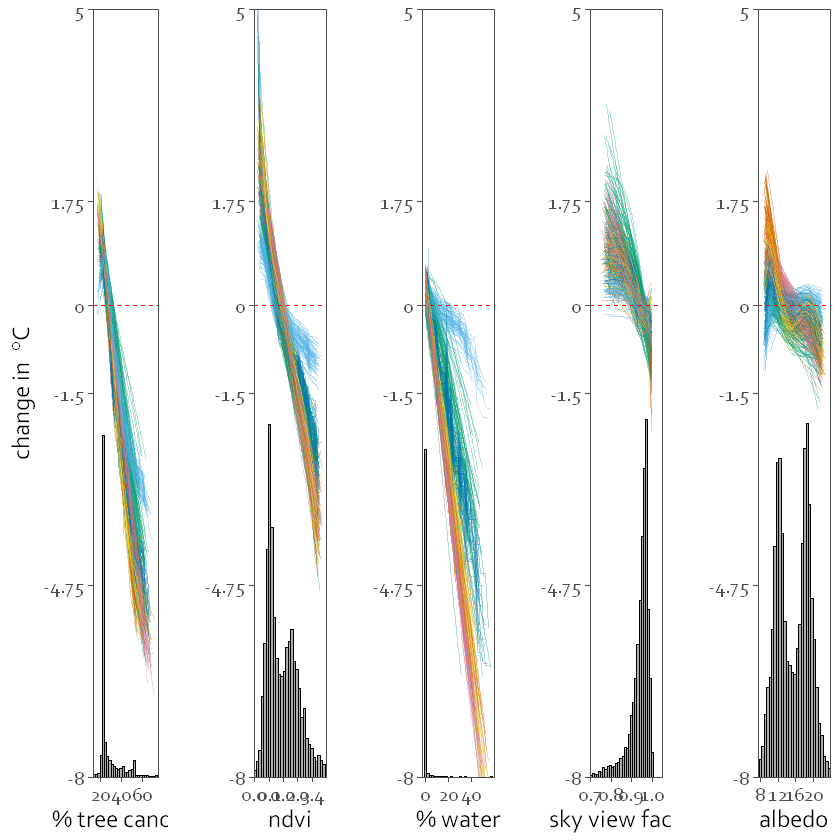

In [13]:
plots.grid <- do.call("grid.arrange", c(plots, ncol=ncol.plot))
outname <- paste0('../../fig/report/pdp_uncert_night_',grid.size,'.png')
ggsave(outname, plots.grid, width=17.8, height=3.5, dpi=500)

In [14]:
dt_sub <- dt[dependent == 'lst_day_mean',]
plots <- list()
# import the feature order
if (grid.size == 500){
    features <- c('lcov_11', 'ndvi_mean', 'tree_mean', 'alb_mean','dsm_mean')
    hist_scaling <- c(12, 0.8, 20, 40, 400)
    } else {
    features = c('tree_mean', 'ndvi_mean', 'alb_mean', 'dsm_mean', 'svf_mean')#, 'alb_mean', 'tree_sd', 'nbdi_sd_sl', 'bldg', 'pdens_mean')
    hist_scaling <- c(25, 0.9, 250, 400, 0.45)
}
# determine the axis limits
y_min <- -8#round(min(dt[,'mean'])*2)/2
y_max <- 5#round(max(dt[,'mean'])*2)/2
ylims <- c(y_min,y_max) - y_min

for (i in seq(length(features))){
    var <- features[[i]]
    # subset the dataframe 
    dt_plot <- dt_sub[independent == var,]
    xlims <- c(min(dt_plot[,x]), max(dt_plot[,x])) + max(dt_plot[,x])*c(-0.05,0.05)
    # plot the lines
    plt <- ggplot(dt_plot,aes(x = x, y = mean - y_min, color = model)) +
        geom_line(aes(group = interaction(model, boot)), alpha = 0.3) +
        geom_hline(yintercept = -y_min, linetype="dashed", color = "red") + 
        xlab(feature_names[var]) + 
        ylab('') + 
        scale_colour_manual(values=cbbPalette) + 
        theme_few()  + 
        theme(text=element_text(size=font.size, family="Corbel"),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = font.size)
             ) + 
        guides(color = guide_legend(override.aes= list(alpha = 1))) +
        scale_y_continuous(breaks = c(seq(ylims[1], ylims[2],length = 5),-y_min), labels= c(seq(y_min,y_max,length = 5),0)) 
        if (i == 1 || i==6){
            plt <- plt + ylab(expression("change in "*~degree*C)) 
            }
#         ggtitle(health_titles[var]) + 
#         theme_black() +
#     if (i == 8){
#         plt <- plt + theme(text=element_text(size=10),
#               legend.title = element_blank(),
#               legend.position="none", 
#               plot.title = element_text(size = 10)
#              )
#         }
    # plot the histogram
    df_hist <- df[as.vector((df[, ..var] >= xlims[1]) & (df[,..var] <= xlims[2])),]
    plt <- plt + geom_histogram(data=df_hist, bins=30, mapping=aes_string(var, paste0('..density..*',hist_scaling[i])), color = 'black', alpha = 0.5)
    plt <- plt + coord_cartesian(ylim=ylims, xlim=xlims, expand=0)  
    # add to list
    plots[[i]] <- plt
#     ggsave('../../fig/report/pdp_uncert_day.png', plt, width=17.8/2.54, height=11.5/2.54)
    }

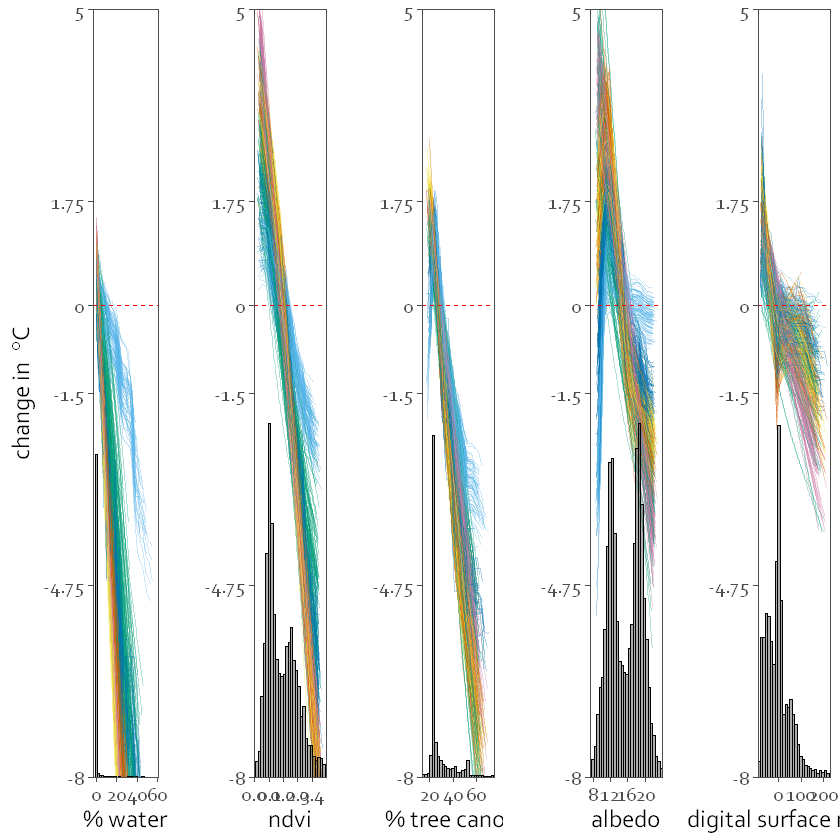

In [15]:
plots.grid <- do.call("grid.arrange", c(plots, ncol=ncol.plot))
outname <- paste0('../../fig/report/pdp_uncert_day_',grid.size,'.png')
ggsave(outname, plots.grid, width=17.8, height=3.5, dpi=500)

In [16]:
dt_sub <- dt[dependent == 'lst_night_max',]
plots <- list()
# import the feature order
if (grid.size == 500){
    features <- c('tree_min', 'ndvi_mean','tree_mean','dsm_mean','svf_mean') # c('lcov_11', 'ndvi_mean', 'tree_mean', 'alb_mean','dsm_mean')
    hist_scaling <- c(11, 0.8, 20, 400, 0.35)
    } else {
    features = c('tree_mean', 'ndvi_mean', 'tree_sd', 'svf_mean', 'alb_mean')#, 'alb_mean', 'tree_sd', 'nbdi_sd_sl', 'bldg', 'pdens_mean')
    hist_scaling <- c(25, 0.9, 10, 0.45, 250)
}
# determine the axis limits
y_min <- -8#round(min(dt[,'mean'])*2)/2
y_max <- 5#round(max(dt[,'mean'])*2)/2
ylims <- c(y_min,y_max) - y_min

for (i in seq(length(features))){
    var <- features[[i]]
    # subset the dataframe 
    dt_plot <- dt_sub[independent == var,]
    xlims <- c(min(dt_plot[,x]), max(dt_plot[,x])) + max(dt_plot[,x])*c(-0.05,0.05)
    # plot the lines
    plt <- ggplot(dt_plot,aes(x = x, y = mean - y_min, color = model)) +
        geom_line(aes(group = interaction(model, boot)), alpha = 0.3) +
        geom_hline(yintercept = -y_min, linetype="dashed", color = "red") + 
        xlab(feature_names[var]) + 
        ylab('') + 
        scale_colour_manual(values=cbbPalette) + 
        theme_few()  + 
        theme(text=element_text(size=font.size, family="Corbel"),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = font.size)
             ) + 
        guides(color = guide_legend(override.aes= list(alpha = 1))) +
        scale_y_continuous(breaks = c(seq(ylims[1], ylims[2],length = 5),-y_min), labels= c(seq(y_min,y_max,length = 5),0)) 
        if (i == 1 || i==6){
            plt <- plt + ylab(expression("change in "*~degree*C)) 
            }
#         ggtitle(health_titles[var]) + 
#         theme_black() +
#     if (i == 8){
#         plt <- plt + theme(text=element_text(size=10),
#               legend.title = element_blank(),
#               legend.position="none", 
#               plot.title = element_text(size = 10)
#              )
#         }
    # plot the histogram
    df_hist <- df[as.vector((df[, ..var] >= xlims[1]) & (df[,..var] <= xlims[2])),]
    plt <- plt + geom_histogram(data=df_hist, bins=30, mapping=aes_string(var, paste0('..density..*',hist_scaling[i])), color = 'black', alpha = 0.5)
    plt <- plt + coord_cartesian(ylim=ylims, xlim=xlims, expand=0)  
    # add to list
    plots[[i]] <- plt
#     ggsave('../../fig/report/pdp_uncert_day.png', plt, width=17.8/2.54, height=11.5/2.54)
    }

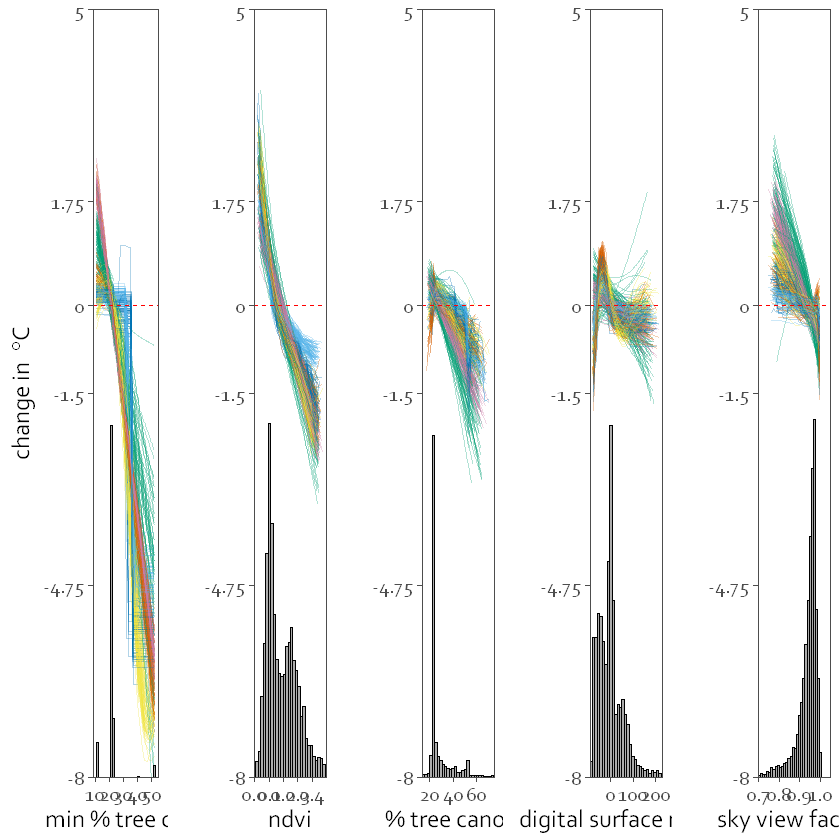

In [17]:
plots.grid <- do.call("grid.arrange", c(plots, ncol=ncol.plot))
outname <- paste0('../../fig/report/pdp_uncert_nightmax_',grid.size,'.png')
ggsave(outname, plots.grid, width=17.8, height=3.5, dpi=500)

In [18]:
dt_sub <- dt[dependent == 'lst_day_max',]
plots <- list()
# import the feature order
if (grid.size == 500){
    features <- c('tree_min', 'ndvi_mean','alb_mean','nbdi_max','lcov_11') # c('lcov_11', 'ndvi_mean', 'tree_mean', 'alb_mean','dsm_mean')
    hist_scaling <- c(11, 0.8, 40, 0.7, 12)
    } else {
    features = c('ndvi_mean', 'tree_mean', 'alb_mean', 'tree_sd', 'dsm_mean')#, 'alb_mean', 'tree_sd', 'nbdi_sd_sl', 'bldg', 'pdens_mean')
    hist_scaling <- c(0.9, 25, 250, 10, 400)
}
# determine the axis limits
y_min <- -8#round(min(dt[,'mean'])*2)/2
y_max <- 5#round(max(dt[,'mean'])*2)/2
ylims <- c(y_min,y_max) - y_min

for (i in seq(length(features))){
    var <- features[[i]]
    # subset the dataframe 
    dt_plot <- dt_sub[independent == var,]
    xlims <- c(min(dt_plot[,x]), max(dt_plot[,x])) + max(dt_plot[,x])*c(-0.05,0.05)
    # plot the lines
    plt <- ggplot(dt_plot,aes(x = x, y = mean - y_min, color = model)) +
        geom_line(aes(group = interaction(model, boot)), alpha = 0.3) +
        geom_hline(yintercept = -y_min, linetype="dashed", color = "red") + 
        xlab(feature_names[var]) + 
        ylab('') + 
        scale_colour_manual(values=cbbPalette) + 
        theme_few()  + 
        theme(text=element_text(size=font.size, family="Corbel"),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = font.size)
             ) + 
        guides(color = guide_legend(override.aes= list(alpha = 1))) +
        scale_y_continuous(breaks = c(seq(ylims[1], ylims[2],length = 5),-y_min), labels= c(seq(y_min,y_max,length = 5),0)) 
        if (i == 1 || i==6){
            plt <- plt + ylab(expression("change in "*~degree*C)) 
            }
#         ggtitle(health_titles[var]) + 
#         theme_black() +
#     if (i == 8){
#         plt <- plt + theme(text=element_text(size=10),
#               legend.title = element_blank(),
#               legend.position="none", 
#               plot.title = element_text(size = 10)
#              )
#         }
    # plot the histogram
    df_hist <- df[as.vector((df[, ..var] >= xlims[1]) & (df[,..var] <= xlims[2])),]
    plt <- plt + geom_histogram(data=df_hist, bins=30, mapping=aes_string(var, paste0('..density..*',hist_scaling[i])), color = 'black', alpha = 0.5)
    plt <- plt + coord_cartesian(ylim=ylims, xlim=xlims, expand=0)  
    # add to list
    plots[[i]] <- plt
#     ggsave('../../fig/report/pdp_uncert_day.png', plt, width=17.8/2.54, height=11.5/2.54)
    }

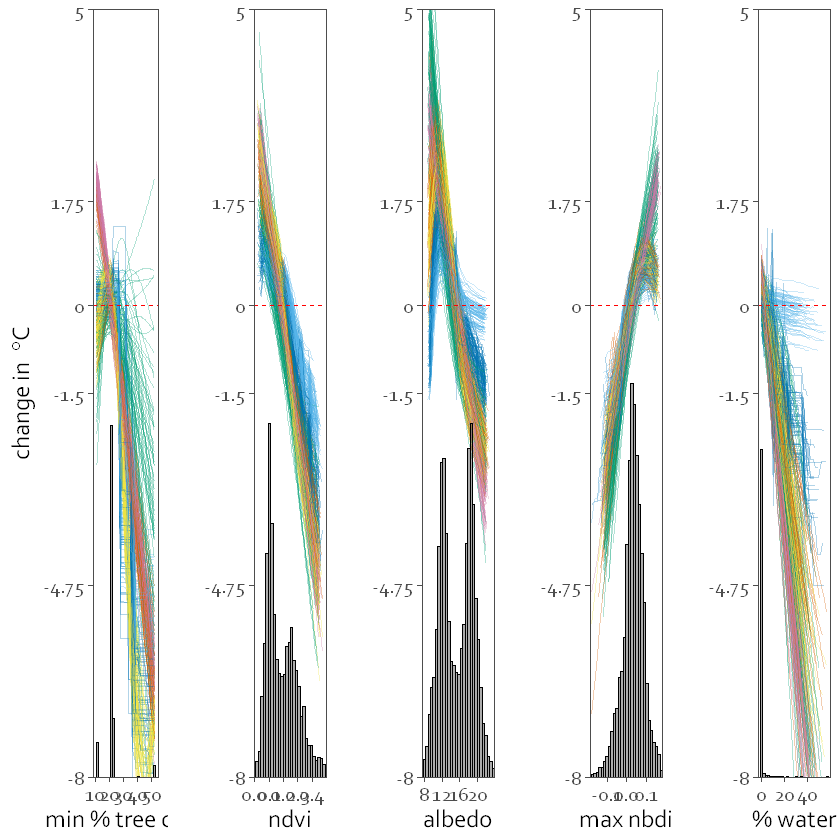

In [19]:
plots.grid <- do.call("grid.arrange", c(plots, ncol=ncol.plot))
outname <- paste0('../../fig/report/pdp_uncert_daymax_',grid.size,'.png')
ggsave(outname, plots.grid, width=17.8, height=3.5, dpi=500)